In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load cleaned data
print("Loading cleaned data...")
try:
    df = pd.read_csv('../data/sf_crime_cleaned.csv')
    print(f"Successfully loaded {len(df):,} records")
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise

Loading cleaned data...
Successfully loaded 874,034 records


In [4]:
# Basic check of cleaned data
print("\nCleaned data summary:")
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())


Cleaned data summary:
Dataset shape: (874034, 15)

First 5 rows:
         Category                      Descript  DayOfWeek PdDistrict  \
0        WARRANTS                WARRANT ARREST  Wednesday   NORTHERN   
1  OTHER OFFENSES      TRAFFIC VIOLATION ARREST  Wednesday   NORTHERN   
2  OTHER OFFENSES      TRAFFIC VIOLATION ARREST  Wednesday   NORTHERN   
3   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO  Wednesday   NORTHERN   
4   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO  Wednesday       PARK   

       Resolution                    Address           X          Y  Year  \
0  ARREST, BOOKED         OAK ST / LAGUNA ST -122.425892  37.774599  2015   
1  ARREST, BOOKED         OAK ST / LAGUNA ST -122.425892  37.774599  2015   
2  ARREST, BOOKED  VANNESS AV / GREENWICH ST -122.424363  37.800414  2015   
3            NONE   1500 Block of LOMBARD ST -122.426995  37.800873  2015   
4            NONE  100 Block of BRODERICK ST -122.438738  37.771541  2015   

   Month  Day  Hour DayOfWeek_Ex

In [5]:
print("\nPerforming data preprocessing...")

# 1. Handle Address column
df['Address'] = df['Address'].astype(str)
df['StreetType'] = df['Address'].str.extract(r'\b(AVE|ST|RD|BLVD|DR)\b', expand=False)
df['StreetType'] = df['StreetType'].fillna('OTHER')

# 2. Create cyclical temporal features
for col in ['Hour', 'Day', 'Month']:
    df[f'{col}_sin'] = np.sin(2 * np.pi * df[col]/df[col].max())
    df[f'{col}_cos'] = np.cos(2 * np.pi * df[col]/df[col].max())

# 3. Drop unnecessary columns
df.drop(columns=[
    'Address', 
    'DayOfWeek_Extracted', 
    'Hour', 
    'Day', 
    'Month'
], inplace=True)

# 4. Encode categorical features
le = LabelEncoder()
categorical_cols = [
    'Descript', 
    'Resolution', 
    'TimeOfDay', 
    'StreetType',
    'DayOfWeek',
    'PdDistrict'
]

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# 5. Convert boolean columns
df['Weekend'] = df['Weekend'].astype(int)



Performing data preprocessing...


In [6]:
df.columns.to_list()

['Category',
 'Descript',
 'DayOfWeek',
 'PdDistrict',
 'Resolution',
 'X',
 'Y',
 'Year',
 'Weekend',
 'TimeOfDay',
 'StreetType',
 'Hour_sin',
 'Hour_cos',
 'Day_sin',
 'Day_cos',
 'Month_sin',
 'Month_cos']

In [7]:
# Prepare features and target
print("\nPreparing features and target...")
X = df.drop(columns=['Category'])
y = df['Category']



Preparing features and target...


In [8]:
X

,Descript,DayOfWeek,PdDistrict,Resolution,X,Y,Year,Weekend,TimeOfDay,StreetType,Hour_sin,Hour_cos,Day_sin,Day_cos,Month_sin,Month_cos
0,866,6,4,0,-122.425892,37.774599,2015,0,1,4,-2.449294e-16,1.0,0.485302,-0.874347,0.5,-0.866025
1,810,6,4,0,-122.425892,37.774599,2015,0,1,4,-2.449294e-16,1.0,0.485302,-0.874347,0.5,-0.866025
2,810,6,4,0,-122.424363,37.800414,2015,0,1,4,-2.449294e-16,1.0,0.485302,-0.874347,0.5,-0.866025
3,404,6,4,11,-122.426995,37.800873,2015,0,1,4,-2.449294e-16,1.0,0.485302,-0.874347,0.5,-0.866025
4,404,6,5,11,-122.438738,37.771541,2015,0,1,4,-2.449294e-16,1.0,0.485302,-0.874347,0.5,-0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874029,661,1,8,11,-122.459033,37.714056,2003,0,1,4,0.000000e+00,1.0,0.937752,0.347305,0.5,0.866025
874030,404,1,2,11,-122.447364,37.731948,2003,0,1,4,0.000000e+00,1.0,0.937752,0.347305,0.5,0.866025
874031,404,1,7,11,-122.403390,37.780266,2003,0,1,4,0.000000e+00,1.0,0.937752,0.347305,0.5,0.866025
874032,496,1,7,11,-122.390531,37.780607,2003,0,1,4,0.000000e+00,1.0,0.937752,0.347305,0.5,0.866025


In [9]:
print("Splitting data into train/test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Maintain class distribution
)

Splitting data into train/test sets...


In [10]:
print("Scaling numerical features...")
scaler = StandardScaler()
num_cols = ['X', 'Y', 'Year']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

Scaling numerical features...


In [11]:
X_train

,Descript,DayOfWeek,PdDistrict,Resolution,X,Y,Year,Weekend,TimeOfDay,StreetType,Hour_sin,Hour_cos,Day_sin,Day_cos,Month_sin,Month_cos
141697,408,6,3,11,-0.118391,-0.028302,1.181093,0,0,4,-9.790841e-01,0.203456,-0.848644,0.528964,1.224647e-16,-1.000000e+00
136482,134,1,8,11,-2.138731,-0.256146,1.181093,0,1,2,-2.449294e-16,1.000000,-0.968077,-0.250653,-5.000000e-01,-8.660254e-01
401336,478,5,5,11,-0.595414,0.172824,0.079653,0,0,4,-9.976688e-01,-0.068242,0.101168,-0.994869,-1.000000e+00,-1.836970e-16
44554,404,3,7,11,0.650905,0.654742,1.456453,1,0,4,-1.361666e-01,-0.990686,0.848644,0.528964,-8.660254e-01,5.000000e-01
416362,548,2,2,11,0.588559,-2.399851,0.079653,1,1,4,7.308360e-01,0.682553,-0.724793,0.688967,1.224647e-16,-1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211971,157,0,3,11,0.612294,-0.482496,0.905733,0,0,4,3.984011e-01,-0.917211,0.485302,-0.874347,-5.000000e-01,-8.660254e-01
641146,587,0,7,0,0.432703,0.578976,-0.746427,0,0,4,-9.790841e-01,0.203456,-0.988468,0.151428,1.000000e+00,6.123234e-17
423894,403,0,0,11,1.364699,-0.666981,0.079653,0,1,4,0.000000e+00,1.000000,0.101168,-0.994869,5.000000e-01,-8.660254e-01
155220,495,0,0,11,1.876440,-1.501157,1.181093,0,0,3,-9.790841e-01,0.203456,-0.651372,-0.758758,8.660254e-01,-5.000000e-01


In [12]:
df.head()

,Category,Descript,DayOfWeek,PdDistrict,Resolution,X,Y,Year,Weekend,TimeOfDay,StreetType,Hour_sin,Hour_cos,Day_sin,Day_cos,Month_sin,Month_cos
0,WARRANTS,866,6,4,0,-122.425892,37.774599,2015,0,1,4,-2.449294e-16,1.0,0.485302,-0.874347,0.5,-0.866025
1,OTHER OFFENSES,810,6,4,0,-122.425892,37.774599,2015,0,1,4,-2.449294e-16,1.0,0.485302,-0.874347,0.5,-0.866025
2,OTHER OFFENSES,810,6,4,0,-122.424363,37.800414,2015,0,1,4,-2.449294e-16,1.0,0.485302,-0.874347,0.5,-0.866025
3,LARCENY/THEFT,404,6,4,11,-122.426995,37.800873,2015,0,1,4,-2.449294e-16,1.0,0.485302,-0.874347,0.5,-0.866025
4,LARCENY/THEFT,404,6,5,11,-122.438738,37.771541,2015,0,1,4,-2.449294e-16,1.0,0.485302,-0.874347,0.5,-0.866025


In [13]:
# Initialize models
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Store results
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'report': classification_report(y_test, y_pred, zero_division=0),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    # Print metrics
    print(f"{name} Accuracy: {results[name]['accuracy']:.4f}")
    print(f"Classification Report:\n{results[name]['report']}")


Training Decision Tree...
Decision Tree Accuracy: 0.9994
Classification Report:
                             precision    recall  f1-score   support

                      ARSON       1.00      1.00      1.00       301
                    ASSAULT       1.00      1.00      1.00     15321
                 BAD CHECKS       1.00      1.00      1.00        81
                    BRIBERY       1.00      1.00      1.00        57
                   BURGLARY       1.00      1.00      1.00      7290
         DISORDERLY CONDUCT       1.00      1.00      1.00       862
DRIVING UNDER THE INFLUENCE       1.00      1.00      1.00       453
              DRUG/NARCOTIC       1.00      1.00      1.00     10780
                DRUNKENNESS       1.00      1.00      1.00       854
               EMBEZZLEMENT       1.00      1.00      1.00       233
                  EXTORTION       1.00      1.00      1.00        51
            FAMILY OFFENSES       1.00      0.99      0.99        97
     FORGERY/COUNTERF

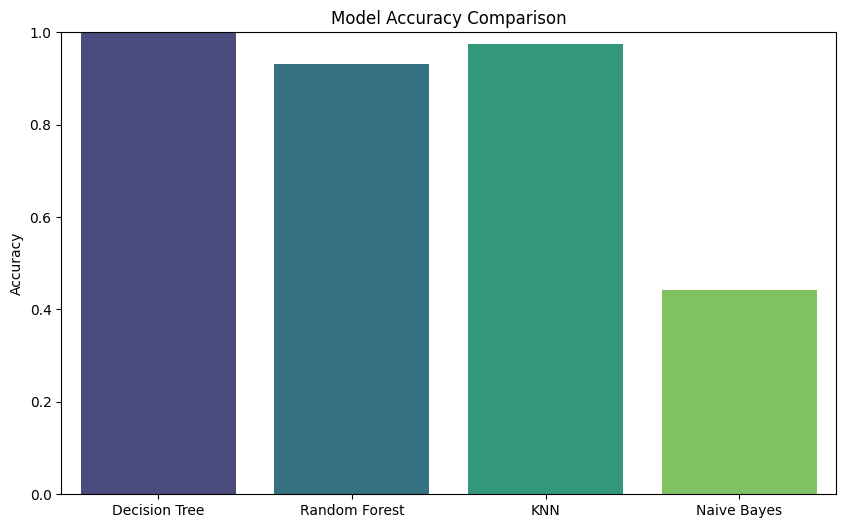

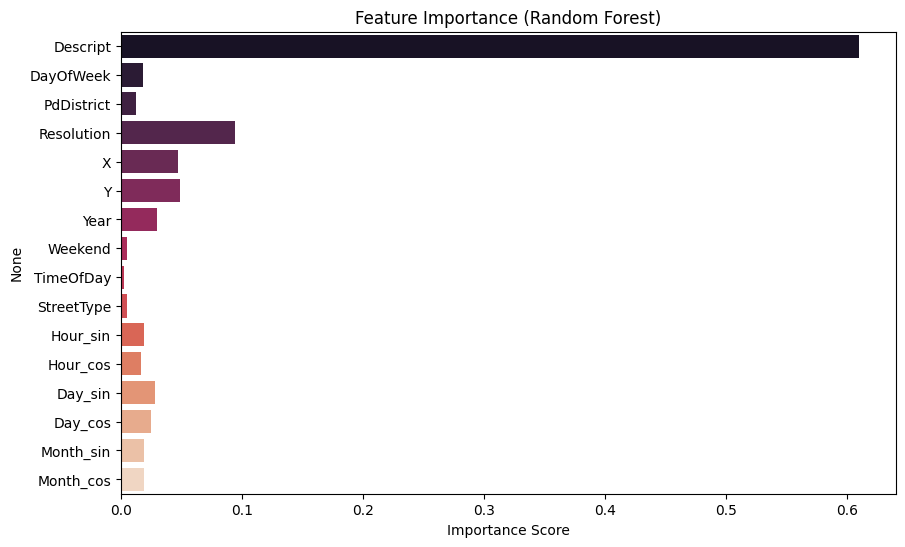

In [14]:
# Visualization of model performance
plt.figure(figsize=(10, 6))
accuracies = [results[name]['accuracy'] for name in models]
sns.barplot(x=list(models.keys()), y=accuracies, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


# Feature importance for Random Forest
rf = models['Random Forest']
importances = rf.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features, palette="rocket")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.show()


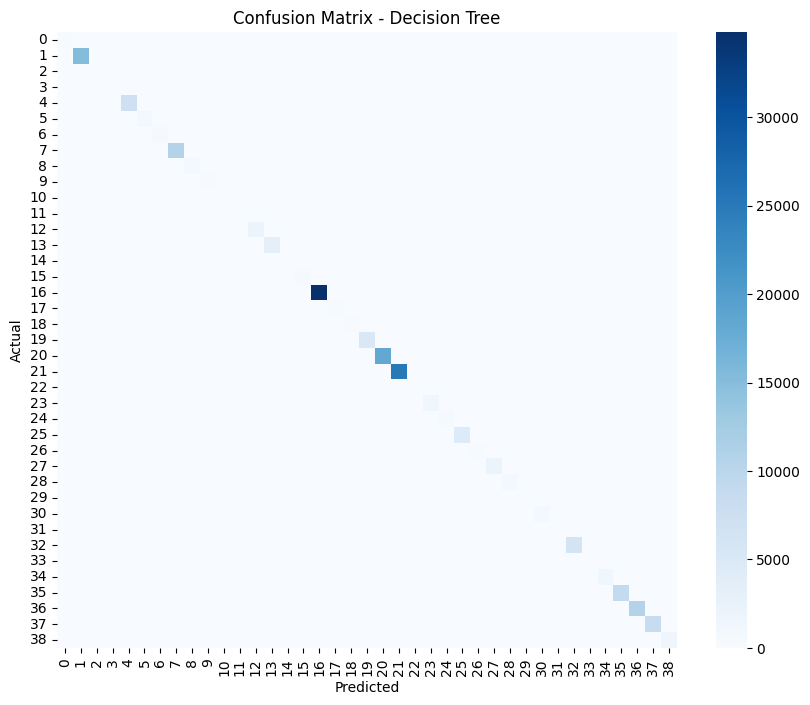

In [15]:
# Confusion matrix for best performing model
best_model_name = max(results, key=lambda k: results[k]['accuracy'])
cm = results[best_model_name]['confusion_matrix']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues", fmt='g')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [16]:
import joblib

# Save best model
best_model = models[best_model_name]
joblib.dump(best_model, f'{best_model_name.replace(" ", "_").lower()}_model.pkl')
print(f"\nBest model '{best_model_name}' saved as '{best_model_name.replace(' ', '_').lower()}_model.pkl'")


Best model 'Decision Tree' saved as 'decision_tree_model.pkl'


In [17]:
import pandas as pd

# Column names matching training features exactly
columns = [
    'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'X', 'Y', 'Year', 'Weekend',
    'TimeOfDay', 'StreetType', 'Hour_sin', 'Hour_cos', 'Day_sin', 'Day_cos', 'Month_sin', 'Month_cos'
]

# Your provided preprocessed data as a list of values
data = [
    408, 6, 3, 11, -0.118391, -0.028302, 1.181093, 0, 0, 4,
    -0.9790841, 0.203456, -0.848644, 0.528964, 1.224647e-16, -1.0
]

# Create single-row DataFrame with correct columns and values
user_df = pd.DataFrame([data], columns=columns)

# Now predict with your models (assuming models dict is ready)
print("\nPredicting crime category from preprocessed input...")

for name, model in models.items():
    prediction = model.predict(user_df)
    print(f"{name} Prediction: {prediction[0]}")



Predicting crime category from preprocessed input...
Decision Tree Prediction: LARCENY/THEFT
Random Forest Prediction: LARCENY/THEFT
KNN Prediction: LARCENY/THEFT
Naive Bayes Prediction: LARCENY/THEFT
